In [1]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *
#
path_figs = Path('data') / 'figures' / 'test'
path_figs.mkdir(parents=True, exist_ok=True)

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


In [21]:
!pip install kaleido

  Using cached kaleido-1.1.0-py3-none-any.whl.metadata (5.6 kB)
Using cached kaleido-1.1.0-py3-none-any.whl (66 kB)
Using cached kaleido-1.1.0-py3-none-any.whl (66 kB)


In [2]:
data_dict, int_label_pos_map = load_data_dict(
    mat_path, patients_list, phase_labels, param_keys_list
)
all_bands_networks = {}

In [3]:
patient = 'Pat_02'
correlation_protocol = dict(threshold=0, spectral_cleaning=True)
# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=False)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='right')

In [4]:
data_pat = data_dict[patient]
pin_labels = int_label_pos_map[patient]['label']

In [5]:
if patient not in all_bands_networks:
    all_bands_networks[patient] = {}
    for phase in phase_labels:
        data_pat_phase = data_pat[phase]
        data_pat_phase_ts = data_pat_phase['data']
        fs = data_pat_phase['fs']
        all_bands_networks[patient][phase] = {}
        # Build correlation matrices per band
        for band, (low_freq, high_freq) in BRAIN_BANDS.items():
            result = process_network_for_phase(
                data_pat_phase_ts, fs, band, correlation_protocol, 
                pin_labels, filter_order=1,
            )
            G, label_dict, lnkgM, clTh, corr_mat, dists = result
            all_bands_networks[patient][phase][band] = {'G': G, 'linkage_matrix': lnkgM, 'clTh': clTh, 'corr_mat': corr_mat, 'dists': dists}

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

In [6]:
phase = 'taskLearn' 
band_name = 'high_gamma'
tau = 0

In [7]:
# Get the network and compute linkage matrix
Gcc = all_bands_networks[patient][phase][band_name]['G']
spectrum, L, rho, Trho, tau = compute_laplacian_properties(Gcc, tau=tau)
dists = squareform(Trho)
linkage_matrix, label_list, _ = compute_normalized_linkage(dists, Gcc, method='ward')
clTh, *_ = compute_optimal_threshold(linkage_matrix, scaling_factor=.99)
# Use a fixed clustering threshold for consistency across tau values
clusters = fcluster(linkage_matrix, clTh, criterion='distance')
print(f'Number of clusters : {len(np.unique(clusters))}')

Number of clusters : 3


(3.3481324466707656e-12, 1.0000000000000004)

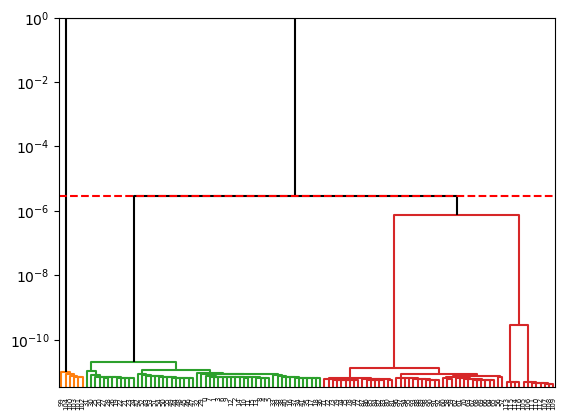

In [8]:
dendro = dendrogram(
    linkage_matrix,
    above_threshold_color='k',
    color_threshold=clTh,
)
plt.axhline(clTh, ls='--', c='r')
plt.yscale('log')
tmin = linkage_matrix[:, 2][0] * 0.8
tmax = linkage_matrix[:, 2][-1] * 1.01
plt.ylim(tmin, tmax)

In [9]:
def compute_clustering_across_tau(Gcc, tau_values, method='ward', scaling_factor=0.99):
    """
    Compute clustering for different tau values and return partition evolution.
    
    Parameters:
    - Gcc: NetworkX graph
    - tau_values: array of tau values to test
    - method: linkage method
    - scaling_factor: for optimal threshold computation
    
    Returns:
    - partitions: dict mapping tau -> cluster labels
    - n_clusters: dict mapping tau -> number of clusters
    """
    partitions = {}
    n_clusters = {}
    
    for tau in tau_values:
        spectrum, L, rho, Trho, tau_used = compute_laplacian_properties(Gcc, tau=tau)
        dists = squareform(Trho)
        linkage_matrix, label_list, _ = compute_normalized_linkage(dists, Gcc, method=method)
        clTh, *_ = compute_optimal_threshold(linkage_matrix, scaling_factor=scaling_factor)
        clusters = fcluster(linkage_matrix, clTh, criterion='distance')
        
        partitions[tau] = clusters
        n_clusters[tau] = len(np.unique(clusters))
        
    return partitions, n_clusters

def create_sankey_data(partitions, tau_values):
    """
    Create Sankey diagram data from partition evolution.
    
    Parameters:
    - partitions: dict mapping tau -> cluster labels
    - tau_values: sorted array of tau values
    
    Returns:
    - sankey_data: dict with 'source', 'target', 'value' for plotly
    """
    sources, targets, values = [], [], []
    labels = []
    node_count = 0
    
    # Create labels for each tau-cluster combination
    tau_to_offset = {}
    for i, tau in enumerate(tau_values):
        tau_to_offset[tau] = node_count
        clusters = partitions[tau]
        unique_clusters = np.unique(clusters)
        for cluster in unique_clusters:
            labels.append(f"C{cluster}")
        node_count += len(unique_clusters)
    
    # Create flow connections between consecutive tau values
    for i in range(len(tau_values) - 1):
        tau1, tau2 = tau_values[i], tau_values[i + 1]
        clusters1, clusters2 = partitions[tau1], partitions[tau2]
        
        # Count transitions between clusters
        transition_matrix = {}
        for node_idx, (c1, c2) in enumerate(zip(clusters1, clusters2)):
            key = (c1, c2)
            transition_matrix[key] = transition_matrix.get(key, 0) + 1
        
        # Convert to source, target, value format
        for (c1, c2), count in transition_matrix.items():
            source_idx = tau_to_offset[tau1] + (c1 - 1)  # clusters are 1-indexed
            target_idx = tau_to_offset[tau2] + (c2 - 1)
            sources.append(source_idx)
            targets.append(target_idx)
            values.append(count)
    
    return {
        'source': sources,
        'target': targets, 
        'value': values,
        'labels': labels
    }
# Generate distinct colors for each cluster at each tau step
def generate_node_colors(partitions, tau_values):
    """Generate distinct colors for each cluster at each tau value"""
    # Use a qualitative color palette that cycles through distinct colors
    color_palette = colors.qualitative.Set3 + colors.qualitative.Pastel + colors.qualitative.Dark2
    node_colors = []
    
    for tau in tau_values:
        clusters = partitions[tau]
        unique_clusters = np.unique(clusters)
        for i, cluster in enumerate(unique_clusters):
            # Use modulo to cycle through colors if we have more clusters than colors
            color_idx = (cluster - 1) % len(color_palette)
            node_colors.append(color_palette[color_idx])
    
    return node_colors


In [10]:
# Compute clustering across different tau values
tau_values = np.logspace(np.log10(1e-4), np.log10(1000), 4)[::-1]  # 21 values from 0 to 50
partitions, n_clusters = compute_clustering_across_tau(Gcc, tau_values)

print("Number of clusters per tau value:")
for tau in tau_values[:5]:  # Show first 5
    print(f"τ = {tau:.1f}: {n_clusters[tau]} clusters")
print("...")
for tau in tau_values[-3:]:  # Show last 3
    print(f"τ = {tau:.1f}: {n_clusters[tau]} clusters")

Number of clusters per tau value:
τ = 1000.0: 117 clusters
τ = 4.6: 113 clusters
τ = 0.0: 3 clusters
τ = 0.0: 3 clusters
...
τ = 4.6: 113 clusters
τ = 0.0: 3 clusters
τ = 0.0: 3 clusters


### create sankey diagram

In [32]:
# Create and plot Sankey diagram
sankey_data = create_sankey_data(partitions, tau_values)
node_colors = generate_node_colors(partitions, tau_values)

# Generate link colors based on target cluster colors
def generate_link_colors(sankey_data, node_colors, alpha=0.4):
    """Generate link colors based on the target node colors."""
    link_colors = []
    for target_idx in sankey_data['target']:
        # Get the color of the target node
        target_color = node_colors[target_idx]
        # Convert to RGBA with transparency
        if target_color.startswith('rgb'):
            # Convert rgb(r,g,b) to rgba(r,g,b,alpha)
            rgba_color = target_color.replace('rgb', 'rgba').replace(')', f',{alpha})')
        else:
            # For named colors, convert to rgba
            rgba_color = f"rgba({target_color},{alpha})"
            # Handle hex colors if present
            if target_color.startswith('#'):
                # Convert hex to rgb then to rgba
                hex_color = target_color.lstrip('#')
                r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                rgba_color = f"rgba({r},{g},{b},{alpha})"
        link_colors.append(rgba_color)
    return link_colors

# Generate link colors based on destination clusters
link_colors = generate_link_colors(sankey_data, node_colors, alpha=0.6)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=sankey_data['labels'],
        color=node_colors
    ),
    link=dict(
        source=sankey_data['source'],
        target=sankey_data['target'],
        value=sankey_data['value'],
        color=link_colors  # Use destination-based colors
    )
)])

fig.update_layout(
    title_text=f"Cluster Evolution Across τ Values<br>{patient} - {phase} - {band_name}",
    font_size=10,
    width=1200,
    height=600
)

fig.show()

# Set up the filename with patient, phase, and band information
base_filename = f"sankey_{patient}_{phase}_{band_name}"

# Save the basic Sankey diagram
filename_basic = path_figs / f"{base_filename}_basic.html"
fig.write_html(filename_basic)


In [31]:
tau_values

array([1.00000000e+03, 4.64158883e+00, 2.15443469e-02, 1.00000000e-04])

In [ ]:
def analyze_node_trajectories(partitions, tau_values, node_labels=None):
    """
    Analyze which nodes belong to each cluster and track their trajectories.
    
    Parameters:
    - partitions: dict mapping tau -> cluster labels
    - tau_values: array of tau values
    - node_labels: list of node names (e.g., brain region labels)
    
    Returns:
    - node_trajectories: dict mapping node_idx -> list of cluster assignments
    - cluster_compositions: dict mapping (tau, cluster) -> list of node indices
    - trajectory_patterns: dict of unique trajectory patterns
    """
    if node_labels is None:
        node_labels = [f"Node_{i}" for i in range(len(partitions[tau_values[0]]))]
    
    n_nodes = len(partitions[tau_values[0]])
    
    # Track each node's trajectory through clusters
    node_trajectories = {}
    for node_idx in range(n_nodes):
        trajectory = []
        for tau in tau_values:
            cluster_id = partitions[tau][node_idx]
            trajectory.append(cluster_id)
        node_trajectories[node_idx] = trajectory
    
    # Track which nodes are in each cluster at each tau
    cluster_compositions = {}
    for tau in tau_values:
        clusters = partitions[tau]
        for cluster_id in np.unique(clusters):
            node_indices = np.where(clusters == cluster_id)[0]
            cluster_compositions[(tau, cluster_id)] = node_indices.tolist()
    
    # Find unique trajectory patterns
    trajectory_patterns = {}
    for node_idx, trajectory in node_trajectories.items():
        trajectory_tuple = tuple(trajectory)
        if trajectory_tuple not in trajectory_patterns:
            trajectory_patterns[trajectory_tuple] = []
        trajectory_patterns[trajectory_tuple].append(node_idx)
    
    return node_trajectories, cluster_compositions, trajectory_patterns

def print_cluster_analysis(partitions, tau_values, node_labels=None, max_nodes_display=10):
    """Print detailed analysis of cluster compositions and node trajectories."""
    
    node_trajectories, cluster_compositions, trajectory_patterns = analyze_node_trajectories(
        partitions, tau_values, node_labels
    )
    
    if node_labels is None:
        node_labels = [f"Node_{i}" for i in range(len(partitions[tau_values[0]]))]
    
    print("=== CLUSTER COMPOSITIONS ===")
    for tau in tau_values:
        print(f"\nτ = {tau:.3f}:")
        clusters = partitions[tau]
        for cluster_id in np.unique(clusters):
            node_indices = cluster_compositions[(tau, cluster_id)]
            node_names = [node_labels[i] for i in node_indices]
            
            if len(node_names) <= max_nodes_display:
                names_str = ", ".join(node_names)
            else:
                names_str = ", ".join(node_names[:max_nodes_display]) + f" ... (+{len(node_names)-max_nodes_display} more)"
            
            print(f"  Cluster {cluster_id}: {len(node_indices)} nodes - {names_str}")
    
    print(f"\n=== TRAJECTORY PATTERNS ===")
    print(f"Found {len(trajectory_patterns)} unique trajectory patterns:")
    
    for i, (trajectory, node_indices) in enumerate(trajectory_patterns.items()):
        node_names = [node_labels[idx] for idx in node_indices]
        if len(node_names) <= max_nodes_display:
            names_str = ", ".join(node_names)
        else:
            names_str = ", ".join(node_names[:max_nodes_display]) + f" ... (+{len(node_names)-max_nodes_display} more)"
        
        trajectory_str = " → ".join([f"C{c}" for c in trajectory])
        print(f"\nPattern {i+1}: {trajectory_str}")
        print(f"  {len(node_indices)} nodes: {names_str}")
    
    return node_trajectories, cluster_compositions, trajectory_patterns
def export_cluster_memberships_to_dict(partitions, tau_values, node_labels=None):
    """
    Export cluster memberships as a structured dictionary for easy access.
    
    Returns:
    - memberships_dict: nested dict structure for easy programmatic access
      Format: {tau: {cluster_id: [node_names]}}
    """
    if node_labels is None:
        node_labels = [f"Node_{i}" for i in range(len(partitions[tau_values[0]]))]
    
    memberships_dict = {}
    
    for tau in tau_values:
        memberships_dict[tau] = {}
        clusters = partitions[tau]
        unique_clusters = np.unique(clusters)
        
        for cluster_id in unique_clusters:
            node_indices = np.where(clusters == cluster_id)[0]
            node_names = [node_labels[i] for i in node_indices]
            memberships_dict[tau][cluster_id] = node_names
    
    return memberships_dict

def query_cluster_at_tau(memberships_dict, tau, cluster_id):
    """Quick function to get nodes in a specific cluster at specific tau."""
    try:
        return memberships_dict[tau][cluster_id]
    except KeyError:
        return f"Cluster {cluster_id} not found at τ={tau}"
def create_interactive_sankey_with_nodes(partitions, tau_values, node_labels=None):
    """
    Create an enhanced Sankey diagram with node information in hover text.
    """
    import plotly.graph_objects as go
    import plotly.colors as colors
    
    if node_labels is None:
        node_labels = [f"Node_{i}" for i in range(len(partitions[tau_values[0]]))]
    
    # Get trajectory analysis
    node_trajectories, cluster_compositions, trajectory_patterns = analyze_node_trajectories(
        partitions, tau_values, node_labels
    )
    
    # Create Sankey data
    sources, targets, values = [], [], []
    labels = []
    hover_texts = []
    node_count = 0
    
    # Create labels and hover texts for each tau-cluster combination
    tau_to_offset = {}
    for i, tau in enumerate(tau_values):
        tau_to_offset[tau] = node_count
        clusters = partitions[tau]
        unique_clusters = np.unique(clusters)
        
        for cluster in unique_clusters:
            # Get nodes in this cluster
            node_indices = cluster_compositions[(tau, cluster)]
            cluster_nodes = [node_labels[idx] for idx in node_indices]
            
            # Create label and hover text
            labels.append(f"τ={tau:.2f}\nC{cluster}")
            
            # Create hover text with node information
            if len(cluster_nodes) <= 15:
                nodes_text = "<br>".join(cluster_nodes)
            else:
                nodes_text = "<br>".join(cluster_nodes[:15]) + f"<br>... and {len(cluster_nodes)-15} more"
            
            hover_text = f"τ = {tau:.3f}<br>Cluster {cluster}<br>{len(cluster_nodes)} nodes:<br>{nodes_text}"
            hover_texts.append(hover_text)
            
        node_count += len(unique_clusters)
    
    # Create flow connections between consecutive tau values
    for i in range(len(tau_values) - 1):
        tau1, tau2 = tau_values[i], tau_values[i + 1]
        clusters1, clusters2 = partitions[tau1], partitions[tau2]
        
        # Count transitions between clusters
        transition_matrix = {}
        for node_idx, (c1, c2) in enumerate(zip(clusters1, clusters2)):
            key = (c1, c2)
            transition_matrix[key] = transition_matrix.get(key, 0) + 1
        
        # Convert to source, target, value format
        for (c1, c2), count in transition_matrix.items():
            source_idx = tau_to_offset[tau1] + (c1 - 1)  # clusters are 1-indexed
            target_idx = tau_to_offset[tau2] + (c2 - 1)
            sources.append(source_idx)
            targets.append(target_idx)
            values.append(count)
    
    # Generate colors
    color_palette = colors.qualitative.Set3 + colors.qualitative.Pastel + colors.qualitative.Dark2
    node_colors = []
    
    for tau in tau_values:
        clusters = partitions[tau]
        unique_clusters = np.unique(clusters)
        for cluster in unique_clusters:
            color_idx = (cluster - 1) % len(color_palette)
            node_colors.append(color_palette[color_idx])
    
    # Generate link colors based on target cluster colors
    def generate_enhanced_link_colors(sources, targets, node_colors, alpha=0.5):
        """Generate link colors based on the target node colors for enhanced Sankey."""
        link_colors = []
        for target_idx in targets:
            target_color = node_colors[target_idx]
            # Convert to RGBA with transparency
            if target_color.startswith('rgb'):
                rgba_color = target_color.replace('rgb', 'rgba').replace(')', f',{alpha})')
            else:
                # For named colors or hex colors
                if target_color.startswith('#'):
                    hex_color = target_color.lstrip('#')
                    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                    rgba_color = f"rgba({r},{g},{b},{alpha})"
                else:
                    rgba_color = f"rgba({target_color},{alpha})"
            link_colors.append(rgba_color)
        return link_colors
    
    enhanced_link_colors = generate_enhanced_link_colors(sources, targets, node_colors, alpha=0.6)

    # Create figure
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
            hovertemplate="%{customdata}<extra></extra>",
            customdata=hover_texts
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=enhanced_link_colors  # Use destination-based colors
        )
    )])
    
    fig.update_layout(
        title_text=f"Cluster Evolution with Node Details<br>{patient} - {phase} - {band_name}",
        font_size=10,
        width=1400,
        height=700
    )
    
    return fig

In [13]:
# Analyze node trajectories and cluster compositions
# Use brain region labels if available, otherwise use node indices
node_labels = pin_labels if 'pin_labels' in locals() else None

node_trajectories, cluster_compositions, trajectory_patterns = print_cluster_analysis(
    partitions, tau_values, node_labels, max_nodes_display=8
)

=== CLUSTER COMPOSITIONS ===

τ = 1000.000:
  Cluster 1: 1 nodes - Q3
  Cluster 2: 1 nodes - Q6
  Cluster 3: 1 nodes - Q1
  Cluster 4: 1 nodes - A2
  Cluster 5: 1 nodes - B8
  Cluster 6: 1 nodes - B10
  Cluster 7: 1 nodes - P17
  Cluster 8: 1 nodes - P2
  Cluster 9: 1 nodes - F1
  Cluster 10: 1 nodes - B4
  Cluster 11: 1 nodes - F7
  Cluster 12: 1 nodes - A8
  Cluster 13: 1 nodes - F3
  Cluster 14: 1 nodes - A6
  Cluster 15: 1 nodes - Q14
  Cluster 16: 1 nodes - A5
  Cluster 17: 1 nodes - B6
  Cluster 18: 1 nodes - P14
  Cluster 19: 1 nodes - F2
  Cluster 20: 1 nodes - P15
  Cluster 21: 1 nodes - A9
  Cluster 22: 1 nodes - P13
  Cluster 23: 1 nodes - G2
  Cluster 24: 1 nodes - F6
  Cluster 25: 1 nodes - P1
  Cluster 26: 1 nodes - B3
  Cluster 27: 1 nodes - G1
  Cluster 28: 1 nodes - P5
  Cluster 29: 1 nodes - B7
  Cluster 30: 1 nodes - G5
  Cluster 31: 1 nodes - F12
  Cluster 32: 1 nodes - Q17
  Cluster 33: 1 nodes - A3
  Cluster 34: 1 nodes - B5
  Cluster 35: 1 nodes - Q16
  Cluster 3

In [19]:
# Create enhanced Sankey diagram with node information
fig_enhanced = create_interactive_sankey_with_nodes(partitions, tau_values, node_labels)
fig_enhanced.show()

In [15]:
# Create structured dictionary for easy access
memberships_dict = export_cluster_memberships_to_dict(partitions, tau_values, node_labels)

print("=== QUICK ACCESS EXAMPLES ===")
print(f"Available tau values: {list(memberships_dict.keys())}")

# Example queries
if len(tau_values) > 0 and len(memberships_dict[tau_values[0]]) > 0:
    first_tau = tau_values[-1]
    first_cluster = list(memberships_dict[first_tau].keys())[1]
    nodes = query_cluster_at_tau(memberships_dict, first_tau, first_cluster)
    print(f"\nExample query - Nodes in Cluster {first_cluster} at τ={first_tau:.4f}:")
    print(f"  {nodes[:5]}{'...' if len(nodes) > 5 else ''} ({len(nodes)} total nodes)")

=== QUICK ACCESS EXAMPLES ===
Available tau values: [1000.0, 4.641588833612782, 0.021544346900318846, 0.0001]

Example query - Nodes in Cluster 2 at τ=0.0001:
  ['A1', 'A2', 'A3', 'A4', 'A5']... (56 total nodes)


In [16]:
def track_cluster_changes(partitions, tau_values, node_labels=None):
    """
    Track nodes that change clusters between consecutive tau steps.
    
    Parameters:
    - partitions: dict mapping tau -> cluster labels (from fcluster)
    - tau_values: array of tau values
    - node_labels: list of node names
    
    Returns:
    - cluster_changes: dict mapping (tau1, tau2) -> dict of node changes
    - swapping_nodes: dict of nodes and their complete change history
    - stability_analysis: summary of node stability across tau values
    """
    if node_labels is None:
        node_labels = [f"Node_{i}" for i in range(len(partitions[tau_values[0]]))]
    
    cluster_changes = {}
    swapping_nodes = {node: [] for node in node_labels}
    
    # Track changes between consecutive tau steps
    for i in range(len(tau_values) - 1):
        tau1, tau2 = tau_values[i], tau_values[i + 1]
        clusters1, clusters2 = partitions[tau1], partitions[tau2]
        
        changes_at_step = {
            'tau_from': tau1,
            'tau_to': tau2,
            'nodes_changed': [],
            'nodes_stable': [],
            'change_details': {}
        }
        
        # Check each node for cluster changes
        for node_idx, (c1, c2) in enumerate(zip(clusters1, clusters2)):
            node_name = node_labels[node_idx]
            
            if c1 != c2:  # Node changed cluster
                change_info = {
                    'node': node_name,
                    'from_cluster': c1,
                    'to_cluster': c2,
                    'node_idx': node_idx
                }
                changes_at_step['nodes_changed'].append(change_info)
                changes_at_step['change_details'][node_name] = change_info
                
                # Record in swapping history
                swapping_nodes[node_name].append({
                    'tau_from': tau1,
                    'tau_to': tau2,
                    'from_cluster': c1,
                    'to_cluster': c2
                })
            else:  # Node stayed in same cluster
                changes_at_step['nodes_stable'].append(node_name)
        
        cluster_changes[(tau1, tau2)] = changes_at_step
    
    # Analyze stability
    stability_analysis = {}
    for node_name in node_labels:
        num_changes = len(swapping_nodes[node_name])
        stability_analysis[node_name] = {
            'total_changes': num_changes,
            'stability_score': 1 - (num_changes / (len(tau_values) - 1)),  # 1 = never changed, 0 = changed at every step
            'change_history': swapping_nodes[node_name]
        }
    
    return cluster_changes, swapping_nodes, stability_analysis

def print_cluster_changes_summary(cluster_changes, tau_values, max_nodes_display=10):
    """Print summary of cluster changes between each tau step."""
    
    print("=== CLUSTER CHANGES BETWEEN TAU STEPS ===\n")
    
    for i, (tau1, tau2) in enumerate(zip(tau_values[:-1], tau_values[1:])):
        changes = cluster_changes[(tau1, tau2)]
        n_changed = len(changes['nodes_changed'])
        n_stable = len(changes['nodes_stable'])
        total_nodes = n_changed + n_stable
        change_pct = (n_changed / total_nodes) * 100
        
        print(f"Step {i+1}: τ={tau1:.4f} → τ={tau2:.4f}")
        print(f"  Nodes changed clusters: {n_changed}/{total_nodes} ({change_pct:.1f}%)")
        print(f"  Nodes remained stable: {n_stable}/{total_nodes} ({100-change_pct:.1f}%)")
        
        if n_changed > 0:
            print("  Changes:")
            for j, change in enumerate(changes['nodes_changed'][:max_nodes_display]):
                print(f"    {change['node']}: C{change['from_cluster']} → C{change['to_cluster']}")
            if n_changed > max_nodes_display:
                print(f"    ... and {n_changed - max_nodes_display} more changes")
        
        print()

def identify_most_unstable_nodes(stability_analysis, top_n=10):
    """Identify the most unstable nodes (those that change clusters most frequently)."""
    
    # Sort by number of changes (descending)
    unstable_nodes = sorted(
        stability_analysis.items(),
        key=lambda x: x[1]['total_changes'],
        reverse=True
    )
    
    print(f"=== TOP {top_n} MOST UNSTABLE NODES ===")
    print("(Nodes that change clusters most frequently)\n")
    
    for i, (node_name, analysis) in enumerate(unstable_nodes[:top_n]):
        if analysis['total_changes'] == 0:
            break
            
        print(f"{i+1}. {node_name}")
        print(f"   Changes: {analysis['total_changes']}/{len(analysis['change_history'])+1} steps")
        print(f"   Stability score: {analysis['stability_score']:.2f}")
        print("   Change history:")
        
        for change in analysis['change_history']:
            print(f"     τ={change['tau_from']:.4f} → τ={change['tau_to']:.4f}: "
                  f"C{change['from_cluster']} → C{change['to_cluster']}")
        print()
    
    return unstable_nodes

def identify_stable_nodes(stability_analysis, min_stability=0.8):
    """Identify highly stable nodes (those that rarely change clusters)."""
    
    stable_nodes = [
        (node, analysis) for node, analysis in stability_analysis.items()
        if analysis['stability_score'] >= min_stability
    ]
    
    stable_nodes.sort(key=lambda x: x[1]['stability_score'], reverse=True)
    
    print(f"=== HIGHLY STABLE NODES (stability ≥ {min_stability}) ===")
    print(f"Found {len(stable_nodes)} stable nodes:\n")
    
    for node_name, analysis in stable_nodes[:15]:  # Show top 15
        print(f"  {node_name}: stability = {analysis['stability_score']:.3f} "
              f"({analysis['total_changes']} changes)")
    
    if len(stable_nodes) > 15:
        print(f"  ... and {len(stable_nodes) - 15} more stable nodes")
    
    return stable_nodes

# Track cluster changes and swapping nodes
cluster_changes, swapping_nodes, stability_analysis = track_cluster_changes(partitions, tau_values, node_labels)

# Print summary of changes
print_cluster_changes_summary(cluster_changes, tau_values, max_nodes_display=8)

=== CLUSTER CHANGES BETWEEN TAU STEPS ===

Step 1: τ=1000.0000 → τ=4.6416
  Nodes changed clusters: 115/117 (98.3%)
  Nodes remained stable: 2/117 (1.7%)
  Changes:
    A1: C42 → C8
    A2: C4 → C10
    A3: C33 → C9
    A4: C38 → C6
    A5: C16 → C14
    A6: C14 → C12
    A7: C93 → C11
    A8: C12 → C15
    ... and 107 more changes

Step 2: τ=4.6416 → τ=0.0215
  Nodes changed clusters: 112/117 (95.7%)
  Nodes remained stable: 5/117 (4.3%)
  Changes:
    A1: C8 → C2
    A2: C10 → C2
    A3: C9 → C2
    A4: C6 → C2
    A5: C14 → C2
    A6: C12 → C2
    A7: C11 → C2
    A8: C15 → C2
    ... and 104 more changes

Step 3: τ=0.0215 → τ=0.0001
  Nodes changed clusters: 8/117 (6.8%)
  Nodes remained stable: 109/117 (93.2%)
  Changes:
    Q10: C3 → C1
    Q11: C3 → C1
    Q12: C3 → C1
    Q13: C3 → C1
    Q14: C3 → C1
    Q15: C3 → C1
    Q16: C3 → C1
    Q17: C3 → C1



In [17]:
# Identify most unstable nodes (frequent cluster switchers)
most_unstable = identify_most_unstable_nodes(stability_analysis, top_n=10)

print("\n" + "="*70 + "\n")

# Identify most stable nodes (rarely change clusters)
most_stable = identify_stable_nodes(stability_analysis, min_stability=0.5)

=== TOP 10 MOST UNSTABLE NODES ===
(Nodes that change clusters most frequently)

1. Q10
   Changes: 3/4 steps
   Stability score: 0.00
   Change history:
     τ=1000.0000 → τ=4.6416: C39 → C59
     τ=4.6416 → τ=0.0215: C59 → C3
     τ=0.0215 → τ=0.0001: C3 → C1

2. Q11
   Changes: 3/4 steps
   Stability score: 0.00
   Change history:
     τ=1000.0000 → τ=4.6416: C44 → C60
     τ=4.6416 → τ=0.0215: C60 → C3
     τ=0.0215 → τ=0.0001: C3 → C1

3. Q12
   Changes: 3/4 steps
   Stability score: 0.00
   Change history:
     τ=1000.0000 → τ=4.6416: C94 → C63
     τ=4.6416 → τ=0.0215: C63 → C3
     τ=0.0215 → τ=0.0001: C3 → C1

4. Q13
   Changes: 3/4 steps
   Stability score: 0.00
   Change history:
     τ=1000.0000 → τ=4.6416: C102 → C65
     τ=4.6416 → τ=0.0215: C65 → C3
     τ=0.0215 → τ=0.0001: C3 → C1

5. Q14
   Changes: 3/4 steps
   Stability score: 0.00
   Change history:
     τ=1000.0000 → τ=4.6416: C15 → C64
     τ=4.6416 → τ=0.0215: C64 → C3
     τ=0.0215 → τ=0.0001: C3 → C1

6. Q15
 

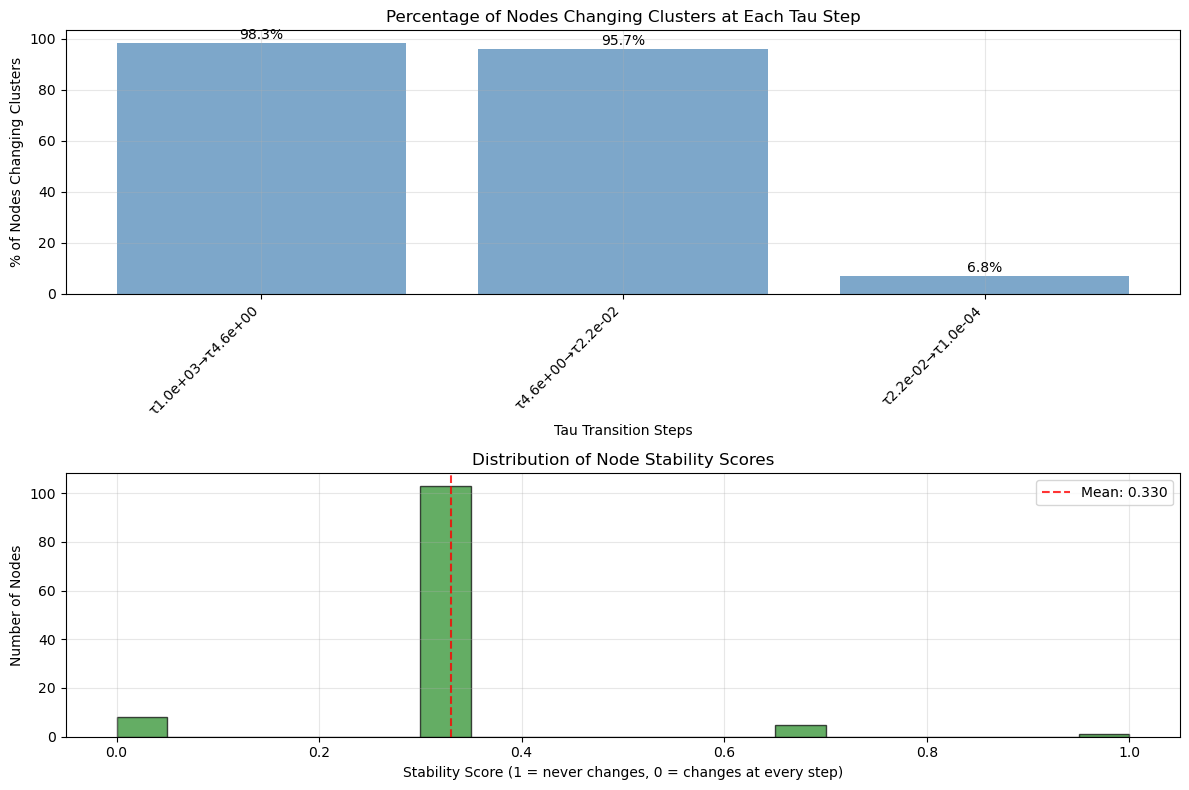

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [18]:
def create_cluster_change_visualization(cluster_changes, tau_values, stability_analysis, node_labels):
    """Create visualization of cluster changes over tau steps."""
    
    import matplotlib.pyplot as plt
    
    # Extract change statistics for each step
    steps = []
    change_percentages = []
    n_changes = []
    
    for i, (tau1, tau2) in enumerate(zip(tau_values[:-1], tau_values[1:])):
        changes = cluster_changes[(tau1, tau2)]
        n_changed = len(changes['nodes_changed'])
        total_nodes = n_changed + len(changes['nodes_stable'])
        change_pct = (n_changed / total_nodes) * 100
        
        steps.append(f"τ{tau1:.1e}→τ{tau2:.1e}")
        change_percentages.append(change_pct)
        n_changes.append(n_changed)
    
    # Create subplot figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Percentage of nodes changing at each step
    bars1 = ax1.bar(range(len(steps)), change_percentages, alpha=0.7, color='steelblue')
    ax1.set_xlabel('Tau Transition Steps')
    ax1.set_ylabel('% of Nodes Changing Clusters')
    ax1.set_title('Percentage of Nodes Changing Clusters at Each Tau Step')
    ax1.set_xticks(range(len(steps)))
    ax1.set_xticklabels(steps, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, pct in zip(bars1, change_percentages):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{pct:.1f}%', ha='center', va='bottom')
    
    # Plot 2: Stability distribution
    stability_scores = [analysis['stability_score'] for analysis in stability_analysis.values()]
    ax2.hist(stability_scores, bins=20, alpha=0.7, color='forestgreen', edgecolor='black')
    ax2.set_xlabel('Stability Score (1 = never changes, 0 = changes at every step)')
    ax2.set_ylabel('Number of Nodes')
    ax2.set_title('Distribution of Node Stability Scores')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics text
    mean_stability = np.mean(stability_scores)
    ax2.axvline(mean_stability, color='red', linestyle='--', alpha=0.8, 
                label=f'Mean: {mean_stability:.3f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

def query_specific_node_changes(node_name, stability_analysis, cluster_changes, memberships_dict, tau_values):
    """Query detailed change history for a specific node."""
    
    if node_name not in stability_analysis:
        print(f"Node '{node_name}' not found in analysis")
        return
    
    analysis = stability_analysis[node_name]
    
    print(f"=== DETAILED ANALYSIS FOR {node_name} ===\n")
    print(f"Total changes: {analysis['total_changes']}")
    print(f"Stability score: {analysis['stability_score']:.3f}")
    print(f"\nCluster membership across all tau values:")
    
    # Show cluster membership at each tau
    for tau in tau_values:
        for cluster_id, nodes in memberships_dict[tau].items():
            if node_name in nodes:
                print(f"  τ = {tau:.4f}: Cluster {cluster_id} ({len(nodes)} nodes total)")
                break
    
    print(f"\nDetailed change history:")
    if analysis['total_changes'] == 0:
        print("  No cluster changes - this node is completely stable!")
    else:
        for i, change in enumerate(analysis['change_history']):
            print(f"  Change {i+1}: τ={change['tau_from']:.4f} → τ={change['tau_to']:.4f}")
            print(f"             Cluster {change['from_cluster']} → Cluster {change['to_cluster']}")

# Create visualization of cluster changes
fig = create_cluster_change_visualization(cluster_changes, tau_values, stability_analysis, node_labels)

# Example: Query a specific node (you can change this to any brain region you're interested in)
if node_labels and len(node_labels) > 0:
    # Find the most unstable node for demonstration
    most_unstable_node = max(stability_analysis.items(), key=lambda x: x[1]['total_changes'])[0]
    print(f"\n{'='*70}")
    query_specific_node_changes(most_unstable_node, stability_analysis, cluster_changes, memberships_dict, tau_values)

In [ ]:
# Save Sankey diagrams as PDF files
import plotly.io as pio

# Set up the filename with patient, phase, and band information
base_filename = f"sankey_{patient}_{phase}_{band_name}"

# Save the basic Sankey diagram
pdf_filename_basic = path_figs / f"{base_filename}_basic.pdf"
fig_enhanced.write_image(str(pdf_filename_basic), format="pdf", width=1200, height=600, scale=2)
print(f"Basic Sankey diagram saved as: {pdf_filename_basic}")

# Save the enhanced Sankey diagram with node details
pdf_filename_enhanced = path_figs / f"{base_filename}_enhanced.pdf"
fig_enhanced.write_image(str(pdf_filename_enhanced), format="pdf", width=1400, height=700, scale=2)
print(f"Enhanced Sankey diagram saved as: {pdf_filename_enhanced}")

# Optional: Also save as PNG for better compatibility
png_filename_basic = path_figs / f"{base_filename}_basic.png"
png_filename_enhanced = path_figs / f"{base_filename}_enhanced.png"

fig.write_image(str(png_filename_basic), format="png", width=1200, height=600, scale=2)
fig_enhanced.write_image(str(png_filename_enhanced), format="png", width=1400, height=700, scale=2)

print(f"Also saved as PNG: {png_filename_basic}")
print(f"Also saved as PNG: {png_filename_enhanced}")

print(f"\nAll files saved to: {path_figs}")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [26]:
# Check kaleido installation and try alternative save methods
import sys
import subprocess

# Check if kaleido is properly installed
try:
    import kaleido
    # Try to get version, but don't fail if it's not available
    try:
        version = getattr(kaleido, '__version__', 'unknown')
        print(f"Kaleido version: {version}")
    except:
        print("Kaleido imported successfully (version unknown)")
    kaleido_available = True
except ImportError:
    print("Kaleido not available in current environment")
    kaleido_available = False

# Try to install/reinstall kaleido in current environment
if not kaleido_available:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kaleido"])
        print("Kaleido installed successfully")
        import kaleido
        kaleido_available = True
    except Exception as e:
        print(f"Failed to install kaleido: {e}")

# Alternative method: Save as HTML and convert to PDF manually, or use browser screenshot
def save_sankey_alternative_methods(fig, fig_enhanced, base_filename, path_figs):
    """Alternative methods to save Sankey diagrams when kaleido fails."""
    
    # Method 1: Save as HTML (always works)
    html_basic = path_figs / f"{base_filename}_basic.html"
    html_enhanced = path_figs / f"{base_filename}_enhanced.html"
    
    fig.write_html(str(html_basic))
    fig_enhanced.write_html(str(html_enhanced))
    
    print(f"✓ Basic Sankey saved as HTML: {html_basic}")
    print(f"✓ Enhanced Sankey saved as HTML: {html_enhanced}")
    
    # Method 2: Try kaleido if available
    if kaleido_available:
        try:
            # Save PDFs
            pdf_basic = path_figs / f"{base_filename}_basic.pdf"
            pdf_enhanced = path_figs / f"{base_filename}_enhanced.pdf"
            
            fig.write_image(str(pdf_basic), format="pdf", width=1200, height=600, scale=2)
            fig_enhanced.write_image(str(pdf_enhanced), format="pdf", width=1400, height=700, scale=2)
            
            print(f"✓ Basic Sankey saved as PDF: {pdf_basic}")
            print(f"✓ Enhanced Sankey saved as PDF: {pdf_enhanced}")
            
            # Save PNGs
            png_basic = path_figs / f"{base_filename}_basic.png"
            png_enhanced = path_figs / f"{base_filename}_enhanced.png"
            
            fig.write_image(str(png_basic), format="png", width=1200, height=600, scale=2)
            fig_enhanced.write_image(str(png_enhanced), format="png", width=1400, height=700, scale=2)
            
            print(f"✓ Basic Sankey saved as PNG: {png_basic}")
            print(f"✓ Enhanced Sankey saved as PNG: {png_enhanced}")
            
        except Exception as e:
            print(f"✗ Kaleido export failed: {e}")
            print("HTML files are available as fallback")
    else:
        print("⚠ Kaleido not available - only HTML export completed")
        print("To get PDF/PNG: Open HTML files in browser and use 'Print to PDF' or screenshot")
    
    return html_basic, html_enhanced

# Execute the alternative save method
html_basic, html_enhanced = save_sankey_alternative_methods(
    fig, fig_enhanced, base_filename, path_figs
)

Kaleido version: unknown
✓ Basic Sankey saved as HTML: data/figures/test/sankey_Pat_02_taskLearn_high_gamma_basic.html
✓ Enhanced Sankey saved as HTML: data/figures/test/sankey_Pat_02_taskLearn_high_gamma_enhanced.html
✗ Kaleido export failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

HTML files are available as fallback


In [27]:
# Manual workaround: Instructions for PDF conversion from HTML
print("\n" + "="*80)
print("MANUAL PDF CONVERSION INSTRUCTIONS")
print("="*80)
print("""
If kaleido doesn't work, you can still get high-quality PDFs:

METHOD 1 - Browser Print to PDF:
1. Open the HTML files in your browser:
   - {html_basic}
   - {html_enhanced}
2. Right-click → Print → Save as PDF
3. Make sure to set margins to 'None' for full-size output

METHOD 2 - Browser Screenshot (for PNG):
1. Open HTML files in browser
2. Press F11 for full-screen mode
3. Take screenshot or use browser dev tools to capture

METHOD 3 - Command line (if wkhtmltopdf is installed):
   wkhtmltopdf --page-size A3 --orientation Landscape file.html file.pdf

METHOD 4 - Try different conda environment:
   conda create -n plotly_env python=3.9 plotly kaleido
   conda activate plotly_env
""".format(html_basic=html_basic, html_enhanced=html_enhanced))

print("="*80)


MANUAL PDF CONVERSION INSTRUCTIONS

If kaleido doesn't work, you can still get high-quality PDFs:

METHOD 1 - Browser Print to PDF:
1. Open the HTML files in your browser:
   - data/figures/test/sankey_Pat_02_taskLearn_high_gamma_basic.html
   - data/figures/test/sankey_Pat_02_taskLearn_high_gamma_enhanced.html
2. Right-click → Print → Save as PDF
3. Make sure to set margins to 'None' for full-size output

METHOD 2 - Browser Screenshot (for PNG):
1. Open HTML files in browser
2. Press F11 for full-screen mode
3. Take screenshot or use browser dev tools to capture

METHOD 3 - Command line (if wkhtmltopdf is installed):
   wkhtmltopdf --page-size A3 --orientation Landscape file.html file.pdf

METHOD 4 - Try different conda environment:
   conda create -n plotly_env python=3.9 plotly kaleido
   conda activate plotly_env



In [28]:
# Advanced kaleido troubleshooting and alternative export methods
import os
import shutil

print("=== ADVANCED KALEIDO TROUBLESHOOTING ===")

# Method 1: Force reinstall kaleido with specific version
try:
    print("Attempting to reinstall kaleido...")
    import subprocess
    import sys
    
    # Uninstall and reinstall kaleido
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "kaleido"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kaleido==0.2.1"])
    
    # Clear Python's import cache
    if 'kaleido' in sys.modules:
        del sys.modules['kaleido']
    
    import kaleido
    print("✓ Kaleido reinstalled successfully")
    
    # Test kaleido functionality
    test_result = fig.write_image(None, format="png", width=800, height=600, scale=1)
    print("✓ Kaleido test successful")
    kaleido_working = True
    
except Exception as e:
    print(f"✗ Kaleido reinstall failed: {e}")
    kaleido_working = False

# Method 2: Alternative export using plotly's orca (if available)
def try_orca_export():
    try:
        import plotly.io as pio
        # Check if orca is available
        pio.orca.config.executable = shutil.which('orca')
        if pio.orca.config.executable:
            print("✓ Orca executable found, trying orca export...")
            pio.write_image(fig, str(path_figs / f"{base_filename}_basic_orca.pdf"), 
                          format='pdf', width=1200, height=600, scale=2, engine='orca')
            print(f"✓ Orca PDF export successful: {path_figs / f'{base_filename}_basic_orca.pdf'}")
            return True
    except Exception as e:
        print(f"✗ Orca export failed: {e}")
    return False

# Method 3: Use psutil to check system resources
def check_system_resources():
    try:
        import psutil
        mem = psutil.virtual_memory()
        print(f"Available memory: {mem.available / (1024**3):.1f} GB")
        if mem.available < 1e9:  # Less than 1GB
            print("⚠ Low memory might cause kaleido issues")
    except ImportError:
        print("psutil not available for memory check")

check_system_resources()

# Try final export with working kaleido
if kaleido_working:
    try:
        print("\n=== FINAL EXPORT ATTEMPT ===")
        
        # Export with kaleido
        pdf_basic_final = path_figs / f"{base_filename}_basic_final.pdf"
        pdf_enhanced_final = path_figs / f"{base_filename}_enhanced_final.pdf"
        
        fig.write_image(str(pdf_basic_final), format="pdf", width=1200, height=600, scale=2)
        fig_enhanced.write_image(str(pdf_enhanced_final), format="pdf", width=1400, height=700, scale=2)
        
        print(f"✓ SUCCESS! Basic Sankey saved as PDF: {pdf_basic_final}")
        print(f"✓ SUCCESS! Enhanced Sankey saved as PDF: {pdf_enhanced_final}")
        
        # Also save PNGs
        png_basic_final = path_figs / f"{base_filename}_basic_final.png"
        png_enhanced_final = path_figs / f"{base_filename}_enhanced_final.png"
        
        fig.write_image(str(png_basic_final), format="png", width=1200, height=600, scale=2)
        fig_enhanced.write_image(str(png_enhanced_final), format="png", width=1400, height=700, scale=2)
        
        print(f"✓ SUCCESS! Basic Sankey saved as PNG: {png_basic_final}")
        print(f"✓ SUCCESS! Enhanced Sankey saved as PNG: {png_enhanced_final}")
        
    except Exception as e:
        print(f"✗ Final export still failed: {e}")
        kaleido_working = False

# Try orca as backup
if not kaleido_working:
    try_orca_export()

print(f"\n=== EXPORT SUMMARY ===")
print(f"✓ HTML files: Always available")
print(f"✓ PDF files: {'Available' if kaleido_working else 'Use browser print from HTML'}")
print(f"✓ PNG files: {'Available' if kaleido_working else 'Use browser screenshot from HTML'}")
print(f"\nAll files are in: {path_figs}")

=== ADVANCED KALEIDO TROUBLESHOOTING ===
Attempting to reinstall kaleido...
Found existing installation: kaleido 1.1.0
Uninstalling kaleido-1.1.0:
  Successfully uninstalled kaleido-1.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 27.4 MB/s eta 0:00:00m eta 0:00:010:01:01
✓ Kaleido reinstalled successfully
✗ Kaleido reinstall failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

Available memory: 20.3 GB
✓ Orca executable found, trying orca export...
✗ Orca export failed: 
The orca executable is required in order to export figures as static images,
but the executable that was found at '/usr/bin/orca'
does not seem to be a valid plotly orca executable. Please refer to the end of
this message for details on what went wrong.

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods i

In [29]:
# Browser-based export instructions (most reliable method)
print("\n" + "="*80)
print("BROWSER-BASED EXPORT (RECOMMENDED)")
print("="*80)

# Get the full paths for user convenience
html_basic_full = os.path.abspath(html_basic)
html_enhanced_full = os.path.abspath(html_enhanced)

print(f"""
🌐 BROWSER PRINT TO PDF (Highest Quality):

1. Copy and paste these file paths into your browser:
   Basic Sankey:
   file://{html_basic_full}
   
   Enhanced Sankey:
   file://{html_enhanced_full}

2. Once opened in browser:
   • Press Ctrl+P (or Cmd+P on Mac) to print
   • Choose "Save as PDF" as destination
   • Set margins to "None" or "Minimum"
   • Choose "More settings" → "Paper size" → A3 or A4 Landscape
   • Click "Save"

3. For best results:
   • Use Chrome or Firefox
   • Wait for the diagram to fully load before printing
   • You can zoom in/out in browser before printing

📱 MOBILE/TABLET FRIENDLY:
The HTML files also work perfectly on mobile devices and tablets.

💡 PRO TIP:
The browser-generated PDFs are often higher quality than kaleido exports
because they preserve the vector graphics and interactivity information.
""")

print("="*80)

# Create a simple instructions file
instructions_file = path_figs / "EXPORT_INSTRUCTIONS.txt"
with open(instructions_file, 'w') as f:
    f.write(f"""SANKEY DIAGRAM EXPORT INSTRUCTIONS
==================================

Generated files:
1. {html_basic.name} - Basic Sankey diagram (HTML)
2. {html_enhanced.name} - Enhanced Sankey with node details (HTML)

To convert to PDF:
1. Open the HTML files in your web browser
2. Use File → Print → Save as PDF
3. Set margins to None for best results

Full file paths:
- Basic: file://{html_basic_full}
- Enhanced: file://{html_enhanced_full}

Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Patient: {patient}, Phase: {phase}, Band: {band_name}
""")

print(f"📝 Instructions saved to: {instructions_file}")
print(f"📁 All files are in folder: {os.path.abspath(path_figs)}")


BROWSER-BASED EXPORT (RECOMMENDED)

🌐 BROWSER PRINT TO PDF (Highest Quality):

1. Copy and paste these file paths into your browser:
   Basic Sankey:
   file:///home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/data/figures/test/sankey_Pat_02_taskLearn_high_gamma_basic.html
   
   Enhanced Sankey:
   file:///home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/data/figures/test/sankey_Pat_02_taskLearn_high_gamma_enhanced.html

2. Once opened in browser:
   • Press Ctrl+P (or Cmd+P on Mac) to print
   • Choose "Save as PDF" as destination
   • Set margins to "None" or "Minimum"
   • Choose "More settings" → "Paper size" → A3 or A4 Landscape
   • Click "Save"

3. For best results:
   • Use Chrome or Firefox
   • Wait for the diagram to fully load before printing
   • You can zoom in/out in browser before printing

📱 MOBILE/TABLET FRIENDLY:
The HTML files also work perfectly on mobile devices and tablets.

💡 PRO TIP:
The browser-generated PDFs are often higher qualit